In [76]:
import time
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import bmi_cfe
import os
from fao_pet import FAO_PET

## Read CAMELS data

In [77]:
data_dir = "G:\Shared drives\SI_NextGen_Aridity\dCFE\data"
basin_id = "01022500"
partitioning_scheme = "Schaake"
soil_scheme = "ode"

In [78]:
output_dir = os.path.join(data_dir, "synthetic_case_from_original_code", partitioning_scheme)
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [79]:
filename = f"{basin_id}_hourly_nldas.csv"
forcing_df = pd.read_csv(os.path.join(data_dir, filename))
forcing_df.set_index(pd.to_datetime(forcing_df["date"]), inplace=True)
forcing_df.head()

# # Convert pandas dataframe to PyTorch tensors
# Convert units
# (precip/1000)   # kg/m2/h = mm/h -> m/h
# (pet/1000/3600) # kg/m2/h = mm/h -> m/s
conversions_m_to_mm = 1000
precip =  forcing_df["total_precipitation"].values / conversions_m_to_mm

pet = FAO_PET(nldas_forcing=forcing_df, basin_id=basin_id).calc_PET().values

In [80]:
filename = f"{basin_id}-usgs-hourly.csv"
obs_q_ = pd.read_csv(os.path.join(data_dir, filename))
obs_q_.set_index(pd.to_datetime(obs_q_["date"]), inplace=True)
q = obs_q_["QObs(mm/h)"].values / conversions_m_to_mm

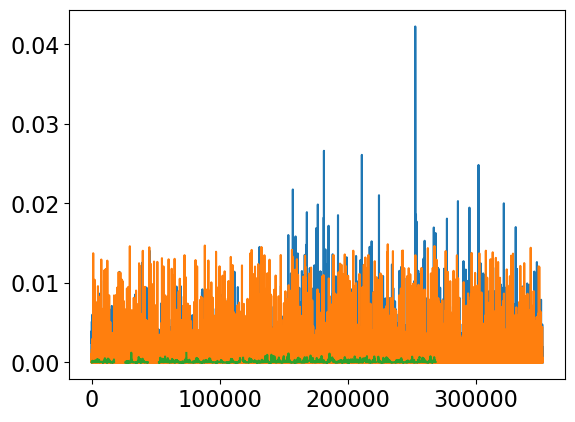

In [81]:
plt.plot(precip)
plt.plot(pet*3600)
plt.plot(q)

## Run Normal CFE Simulations

In [82]:
filename = f"cat_{basin_id}_bmi_config_cfe.json"
cfe_instance = bmi_cfe.BMI_CFE(cfg_file=os.path.join(data_dir, filename), soil_scheme=soil_scheme, partitioning_scheme=partitioning_scheme)
cfe_instance.stand_alone = 0
cfe_instance.initialize()

In [83]:
outputs = cfe_instance.get_output_var_names()
output_lists = {output:[] for output in outputs}

for precip_t, pet_t in zip(precip, pet):
    
    cfe_instance.set_value('atmosphere_water__time_integral_of_precipitation_mass_flux', precip_t)
    cfe_instance.set_value("water_potential_evaporation_flux", pet_t)
    
    cfe_instance.update()
    
    for output in outputs:
    
        output_lists[output].append(cfe_instance.get_value(output))

In [84]:
cfe_instance.finalize(print_mass_balance=True)


GLOBAL MASS BALANCE
  initial volume:   0.4978
    volume input:  47.6137
   volume output:  47.6188
    final volume:   0.4927
        residual: 9.0534e-12

PARTITION MASS BALANCE
    surface runoff:   0.7350
      infiltration:  42.5299
 vol. et from rain:   4.3488
partition residual: -7.3896e-13

GIUH MASS BALANCE
  vol. into giuh:   0.7350
   vol. out giuh:   0.7350
 vol. end giuh q:   0.0000
   giuh residual: -4.9960e-15

SOIL WATER MASS BALANCE
     init soil vol:   0.4976
    vol. into soil:  42.5299
  vol.soil2latflow:   3.8943
   vol. soil to gw:   1.6276
 vol. et from soil:  37.0130
   final vol. soil:   0.4926
  vol. soil resid.: -5.0820e-13

NASH CASCADE CONCEPTUAL RESERVOIR MASS BALANCE
    vol. to nash:   3.8943
  vol. from nash:   3.8943
 final vol. nash:   0.0000
nash casc resid.: 2.0265e-13

GROUNDWATER CONCEPTUAL RESERVOIR MASS BALANCE
init gw. storage:   0.0002
       vol to gw:   1.6276
     vol from gw:   1.6277
final gw.storage:   0.0001
    gw. residual: 2.1173e

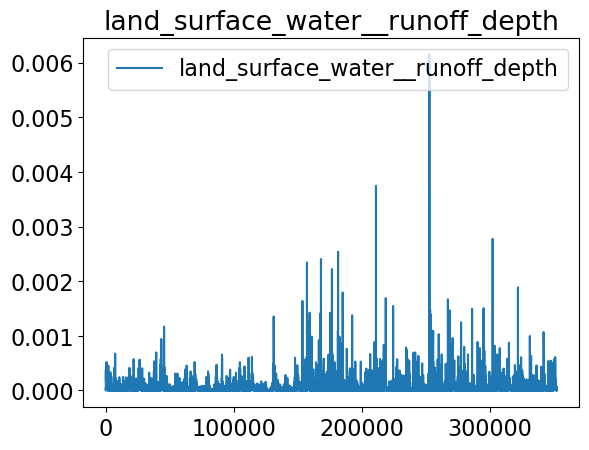

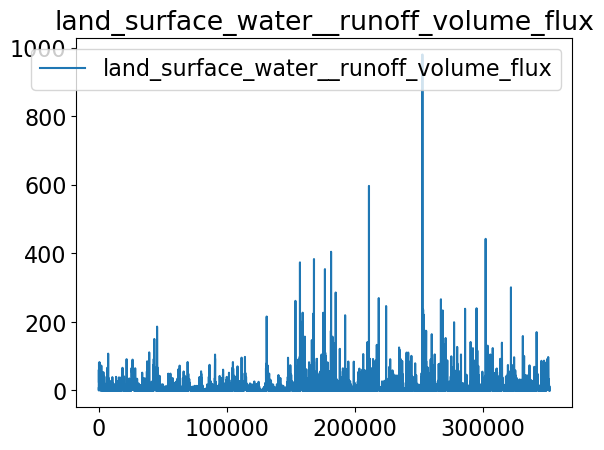

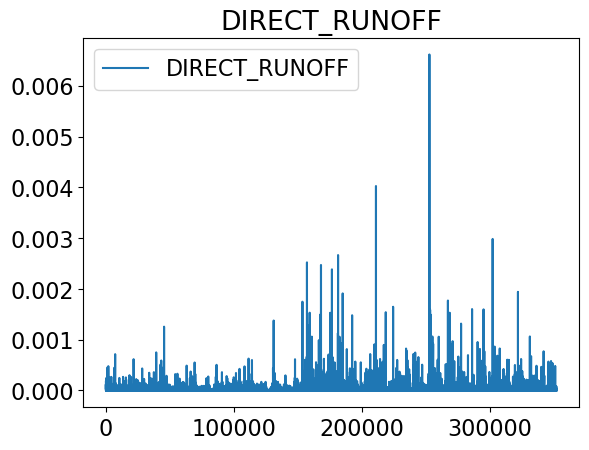

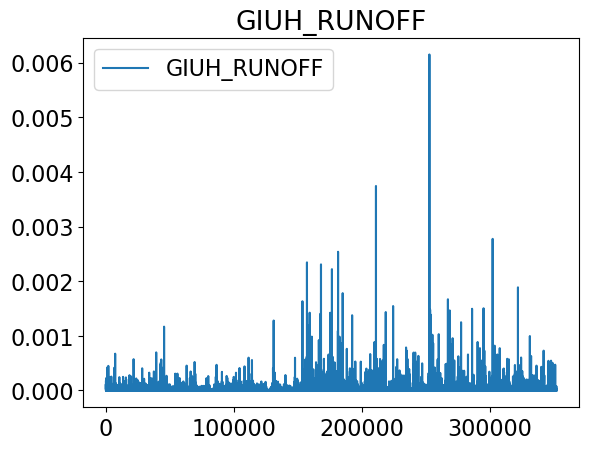

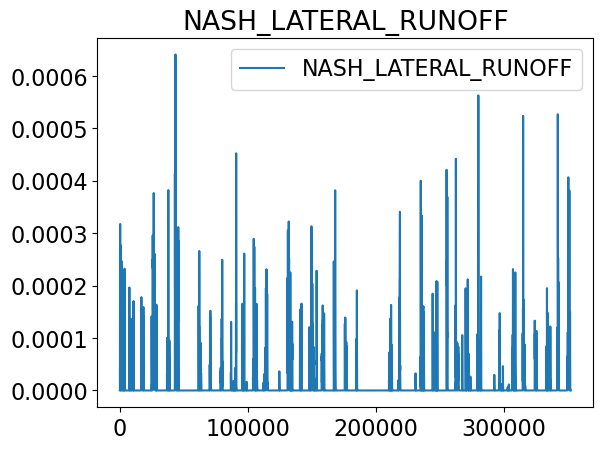

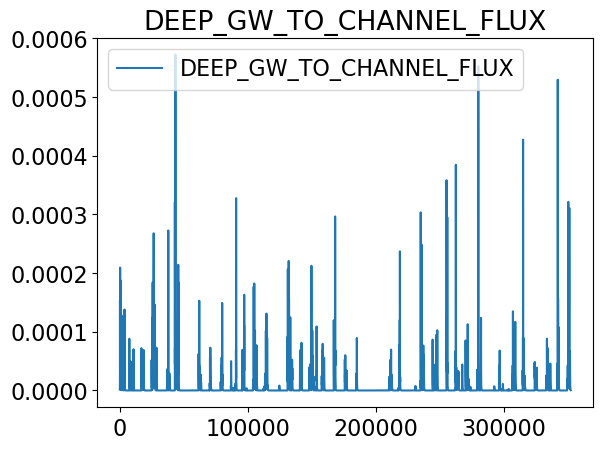

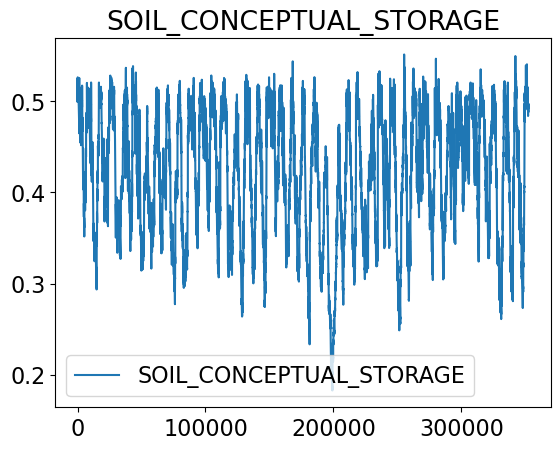

In [85]:
# istart_plot = 490
# iend_plot = 550
# x = list(range(istart_plot, iend_plot))
for output in outputs:
    plt.plot(output_lists[output], label=output)
    plt.title(output)
    plt.legend()
    plt.show()
    plt.close()

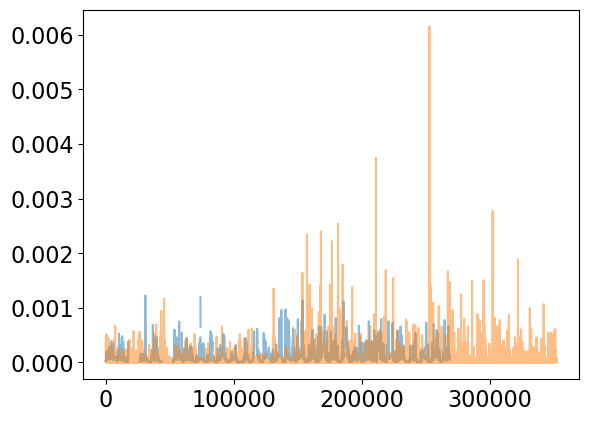

In [86]:
plt.plot(obs_q_["QObs(mm/h)"].values/conversions_m_to_mm, alpha=.5)
plt.plot(output_lists["land_surface_water__runoff_depth"], alpha=.5)

# Save results

In [87]:
sim_q = np.array(output_lists["land_surface_water__runoff_depth"])

In [88]:

# Create a pandas DataFrame from the indexed list
output_df = pd.DataFrame(sim_q, index=forcing_df.index, columns=["simQ[m/hr]"])
output_df.head()

,simQ[m/hr]
time,
1979-01-01 13:00:00,0.000041
1979-01-01 14:00:00,0.000014
1979-01-01 15:00:00,0.000008
1979-01-01 16:00:00,0.000009
1979-01-01 17:00:00,0.000002


In [89]:
filename = f"{basin_id}_synthetic_{soil_scheme}.csv"
output_df.to_csv(os.path.join(output_dir, filename))